**Import required libraries**

In [14]:
import pandas as pd
import requests
import json
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**Get latest historical prices of BTC using coingecko API**

In [ ]:
def get_new_prices(historical_data):
    """
    Parameters
    ----------
    historical_data : DF
        Df read from csv containing all the historical prices by day.

    Returns
    -------
    None: - Finds the days discrepency between csv file and data on api and
    uses get_historical prices and appends the new data to existing_csv

    """

    # need try statement as if csv is open with excel it re orders the dates
    try:
        historical_data['Date'] = pd.to_datetime(historical_data['Date'], format = '%Y/%m/%d')
    except ValueError:
        historical_data['Date'] = pd.to_datetime(historical_data['Date'], format = '%d/%m/%Y')
    #
    max_date = historical_data['Date'].max()
    today_date = pd.to_datetime("today")
    date_difference = (today_date - max_date).days
    if date_difference > 0:
        chosen_currency = historical_data['Currency'][0]
        get_historical_prices(chosen_currency, date_difference, False)
    else:
        return

In [ ]:
def get_historical_prices(chosen_currency, num_days, first_parse):
    """
    Parameters
    ----------
    chosen_currency : STR
        Provide a valid crypto currency e.g. 'bitcoin'.
    num_days : INT
        Enter the number of days history wanted.
    Returns
    -------
    data : DF
        Returns df of dates and the historical prices.

    """

    response = requests.get(f'https://api.coingecko.com/api/v3/coins/{chosen_currency}/market_chart?vs_currency=usd&days={num_days}&interval=daily')
    hist_dict = response.json()

    data = pd.DataFrame.from_dict(hist_dict['prices'])
    data.rename(columns = {0: 'Date', 1: 'Price(USD)'}, inplace = True)
    data['Date'] = pd.to_datetime(data['Date'], unit = 'ms')
    data['Date'] = data['Date'].dt.date
    data['Currency'] = chosen_currency

    if first_parse is False:
        data.to_csv(f'/content/{chosen_currency}_daily_historical.csv', mode='a', header=False, index = False)
    else:
        data.to_csv(f'/content/{chosen_currency}_daily_historical.csv', index = False)

In [ ]:
chosen_currency = 'bitcoin'
try:
  historical_data = pd.read_csv(f'/content/{chosen_currency}_daily_historical.csv')
except FileNotFoundError:
  historical_data  = pd.DataFrame()

if len(historical_data) > 0:
  get_new_prices(historical_data)
else:
  get_historical_prices(chosen_currency, 3650, True)

In [4]:
# Import the generated CSV file for the generated BTC prices
df=pd.read_csv('bitcoin_daily_historical.csv', index_col='Date', parse_dates=True)

**Feature Engineering & Data Analysis**

In [5]:
df.drop('Currency', axis=1, inplace=True)

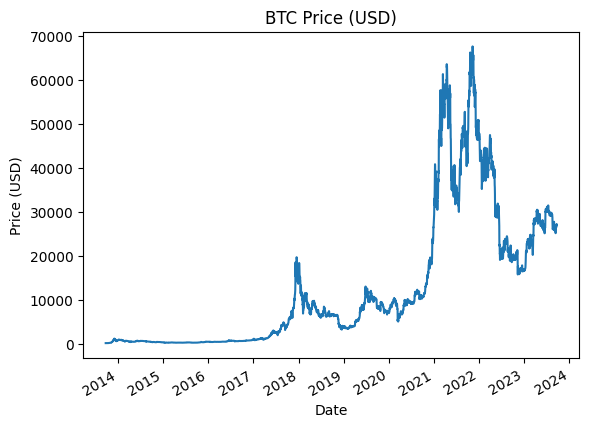

In [7]:

# Plot the 'Price(USD)' column
df['Price(USD)'].plot()

# Set the title and labels for the plot
plt.title('BTC Price (USD)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Show the plot
plt.show()

In [8]:
df = df.reset_index()

# Filter the DataFrame for dates after 2016-12-31
df = df[df['Date'] > '2016-12-31']

# Set the index of the filtered DataFrame to be the original Date column
df = df.set_index('Date')

In [9]:
df

,Price(USD)
Date,
2017-01-01,998.050000
2017-01-02,1019.198800
2017-01-03,1035.531300
2017-01-04,1130.849516
2017-01-05,990.667500
...,...
2023-09-17,26557.768692
2023-09-18,26520.988255
2023-09-19,26741.461111


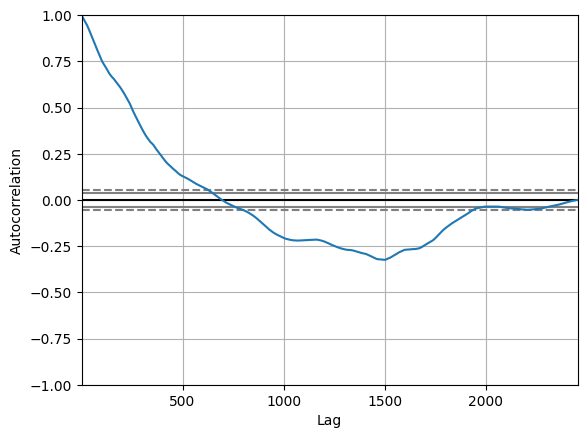

In [10]:
autocorrelation_plot(df)
plt.show()

In [ ]:
index=int(len(df)*0.85)
df_train=df[0:index]
df_test=df[index:]

In [ ]:
df_train

,Price(USD)
Date,
2017-01-01,998.050000
2017-01-02,1019.198800
2017-01-03,1035.531300
2017-01-04,1130.849516
2017-01-05,990.667500
...,...
2022-09-13,22339.670503
2022-09-14,20184.967492
2022-09-15,20255.922978


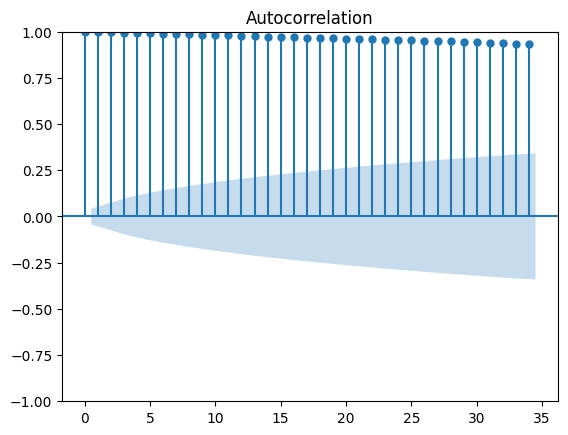

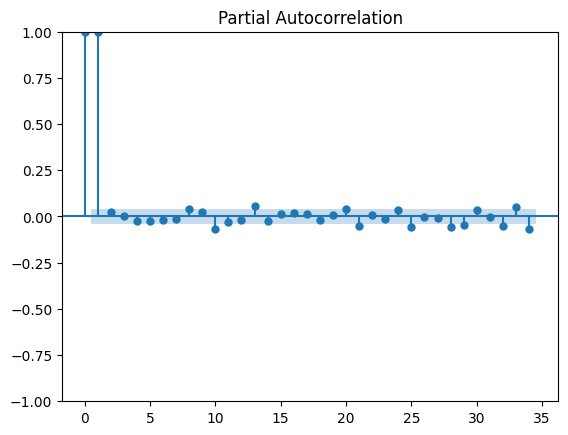

In [ ]:
# The ACF plot shows the correlation between the time series and its lagged values.
# The PACF plot shows the correlation between the time series and its lagged values, while controlling for the effects of intermediate lags.


acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

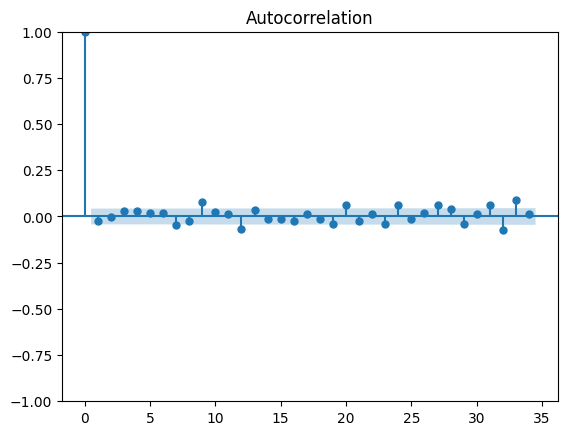

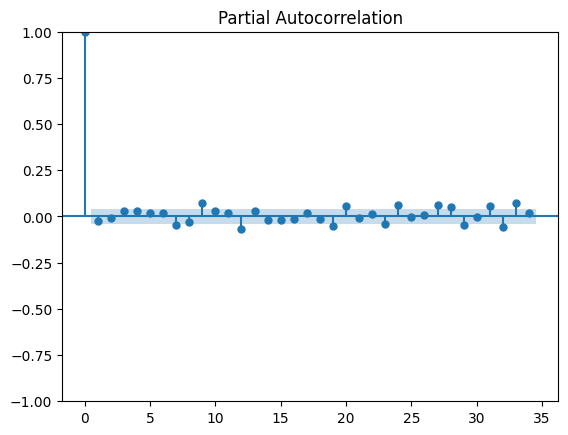

In [ ]:
acf_diff1 = plot_acf(df_train.diff().dropna())

pacf_diff1 = plot_pacf(df_train.diff().dropna())

In [ ]:
result = adfuller(df_train['Price(USD)'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.5094383380732537
p-value: 0.528837268433234
Critical Values:
	1%: -3.433533023432548
	5%: -2.8629461097716633
	10%: -2.567518549139982


**Modelling**

In [ ]:
train_data=list(df_train['Price(USD)'].values)
test_data=list(df_test['Price(USD)'].values)

In [ ]:
model_predictions=[]
num_test= len(test_data)

In [ ]:
# We append each value of the test data to the training data, before re-fitting the model with the updated data.
for i in range(num_test):
  model=ARIMA(df_train, order=(1,1,1))
  model_fit= model.fit()
  output=model_fit.forecast()
  model_predictions.append(output[0])
  actual_price_test=test_data[i]
  train_data.append(actual_price_test)

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2449
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20147.736
Date:                Tue, 19 Sep 2023   AIC                          40301.472
Time:                        21:43:02   BIC                          40318.881
Sample:                             0   HQIC                         40307.799
                               - 2449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0375      0.485     -0.077      0.938      -0.988       0.913
ma.L1          0.0139      0.486      0.029      0.977      -0.938       0.966
sigma2       8.26e+05   9073.876     91.027      0.0

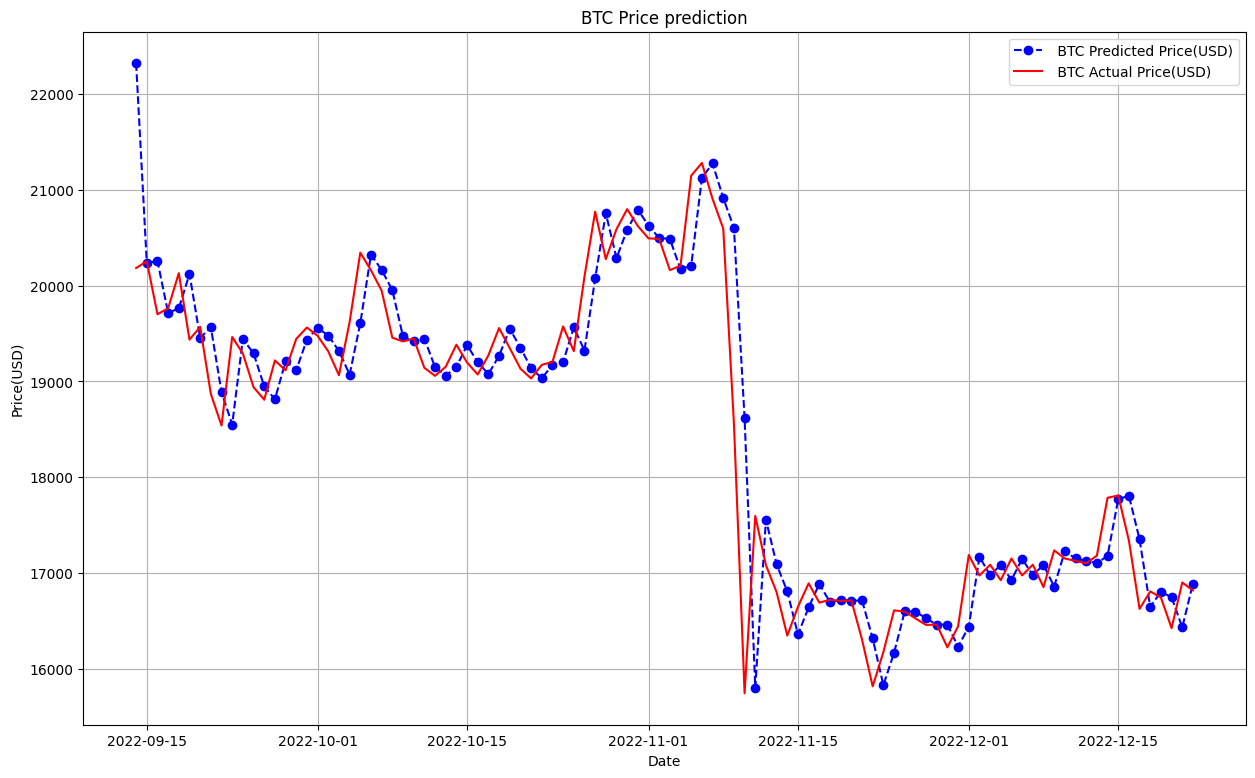

In [ ]:
plt.figure(figsize=(15,9))
plt.grid(True)
date_range=df_test[0:100].index

plt.plot(date_range, model_predictions[0:100], color='blue', marker= 'o' , linestyle='dashed', label=' BTC Predicted Price(USD)' )
plt.plot(date_range, test_data[0:100], color='red', label=' BTC Actual Price(USD)' )

plt.title("BTC Price prediction")
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.show()

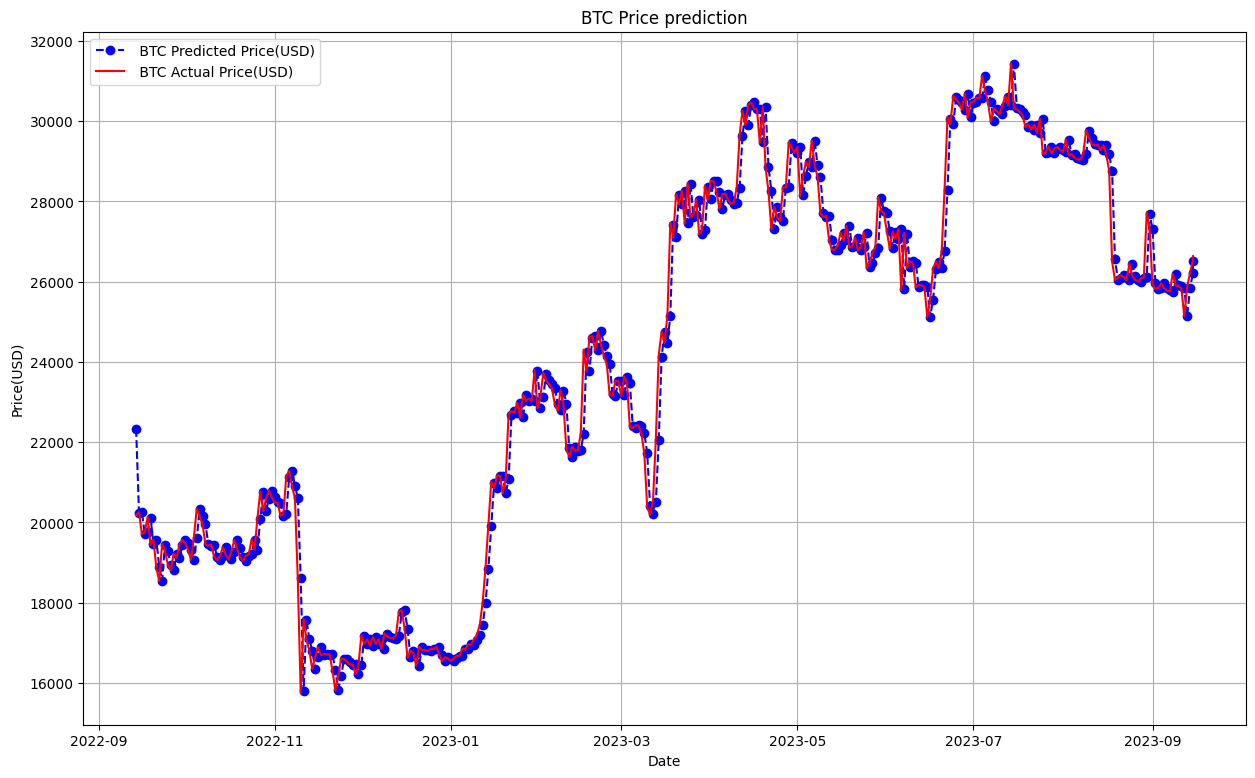

In [ ]:
plt.figure(figsize=(15,9))
plt.grid(True)
date_range=df_test.index

plt.plot(date_range, model_predictions, color='blue', marker= 'o' , linestyle='dashed', label=' BTC Predicted Price(USD)' )
plt.plot(date_range, test_data, color='red', label=' BTC Actual Price(USD)' )

plt.title("BTC Price prediction")
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.show()

**Evaulation**

In [ ]:
def rmse(test_data, model_predictions):
  """Calculates the root mean squared error between two lists."""
  squared_errors = []
  for i in range(len(test_data)):
    squared_errors.append((test_data[i] - model_predictions[i])**2)
  rmse = np.sqrt(np.mean(squared_errors))
  return rmse

# Calculate the RMSE
rmse = rmse(test_data, model_predictions)

# Print the RMSE
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 579.0


In [ ]:
mape=np.mean(abs(np.array(model_predictions)-np.array(test_data))/np.abs(test_data))

In [ ]:
mape # mean Absolute Percentage error

0.016029967641884003

In [ ]:
# Make a prediction for one day ahead
prediction = model_fit.predict(start=len(df), end=len(df) + 1)

# Print the prediction
print(prediction)

[26524.51429767 26524.50423449]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
